In [1]:
import PIL
import torch
import requests
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
path = "C:\\Users\\goura\\Downloads\\Data Science Course\\Python Notes\\Deep Learning"
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [4]:
train_dataset = datasets.MNIST(root = path, train=True, transform=transform, download=True)
train_dataset

100%|██████████| 9912422/9912422 [00:00<00:00, 174502361.96it/s]


Extracting C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning/MNIST/raw/train-images-idx3-ubyte.gz to C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53885984.80it/s]

Extracting C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning/MNIST/raw/train-labels-idx1-ubyte.gz to C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 39181078.78it/s]


Extracting C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning/MNIST/raw/t10k-images-idx3-ubyte.gz to C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1819187.24it/s]


Extracting C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning/MNIST/raw/t10k-labels-idx1-ubyte.gz to C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
val_dataset = datasets.MNIST(root = path, train=False, transform=transform, download=True)
val_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: C:\Users\goura\Downloads\Data Science Course\Python Notes\Deep Learning
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)

### Preprocessing of Image:

In [7]:
def image_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5,)) + np.array((0.5,))
    image = image.clip(0,1)
    return image

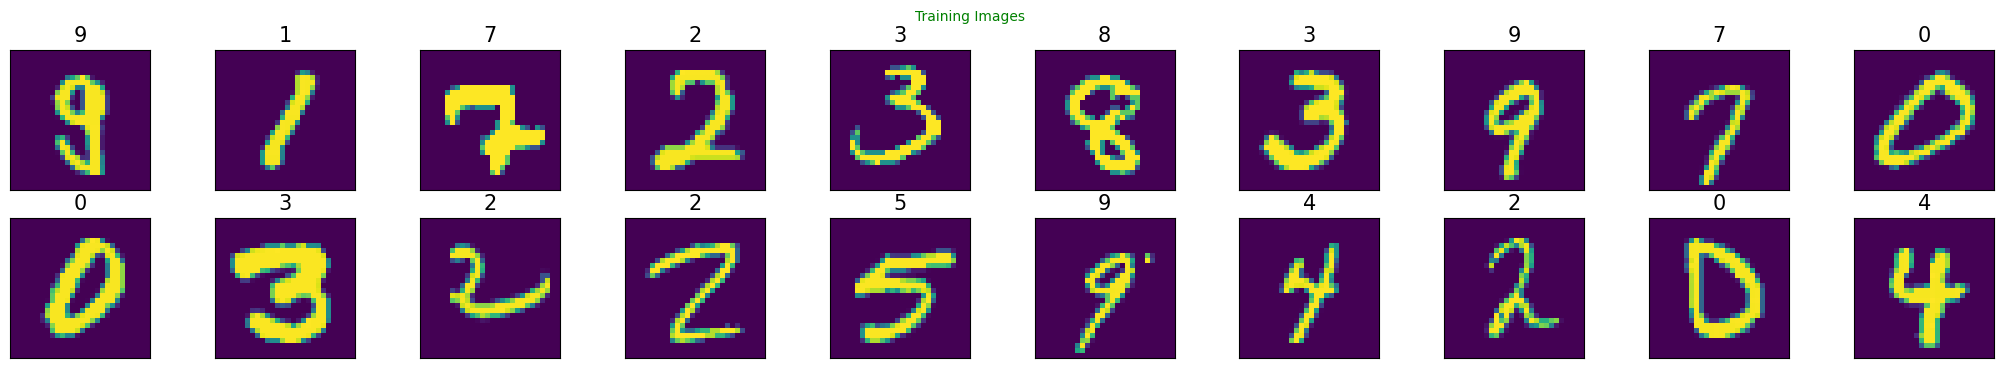

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(26,4))
for i in range(20):
    ax = plt.subplot(2,10,i+1, xticks=[], yticks=[])
    plt.imshow(image_convert(images[i]))
    ax.set_title(labels[i].item(), fontsize=15)
    plt.suptitle('Training Images', fontsize=10, color='g')

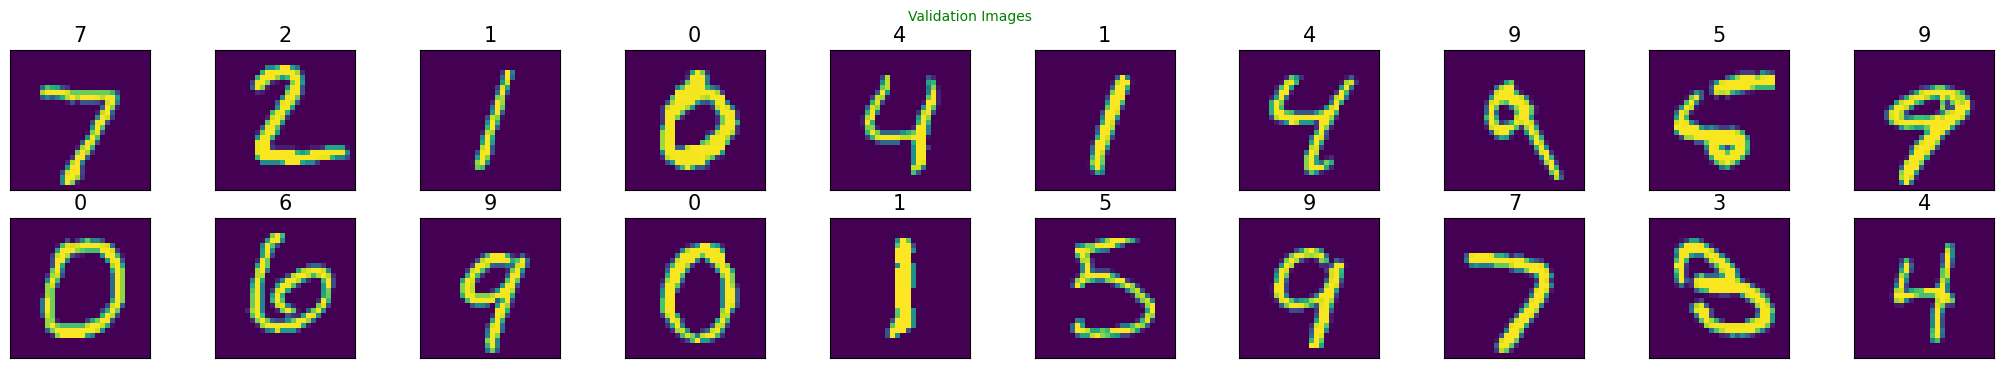

In [9]:
dataiter_val = iter(val_loader)
images_val, labels_val = next(dataiter_val)
plt.figure(figsize=(26,4))
for i in range(20):
    ax_val = plt.subplot(2,10,i+1, xticks=[], yticks=[])
    plt.imshow(image_convert(images_val[i]))
    ax_val.set_title(labels_val[i].item(), fontsize=15)
    plt.suptitle('Validation Images', fontsize=10, color='g')

### Defining our LeNet Model:

In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=20,kernel_size=5,stride=1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500,10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        # 2,2 because window size is 2x2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [11]:
torch.manual_seed(1)
model = LeNet().to(device)
list(model.parameters())
print(model)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [12]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Model Training:

In [13]:
epochs = 15
running_acc_history = []
running_loss_history = []
val_running_acc_history = []
val_running_loss_history = []
for epoch in range(epochs):
    running_acc = 0.0
    running_loss = 0.0
    val_running_acc = 0.0
    val_running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == labels.data)
        loss = criteria(outputs, labels)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    else:
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                # val_inputs = val_inputs.view(val_inputs.shape[0],-1)
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_, val_preds = torch.max(val_outputs, 1)
                val_running_acc += torch.sum(val_preds == val_labels.data)
                val_loss = criteria(val_outputs, val_labels)
                val_running_loss += val_loss.item()

        val_epoch_acc = val_running_acc / len(val_loader)
        val_running_acc_history.append(val_epoch_acc.item())
        val_epoch_loss = val_running_loss / len(val_loader)
        val_running_loss_history.append(val_epoch_loss)

        epoch_acc = running_acc / len(train_loader)
        running_acc_history.append(epoch_acc.item())
        epoch_loss = running_loss / len(train_loader)
        running_loss_history.append(epoch_loss)

        print("epoch: ", epoch+1)
        print("Training   Loss: {:.7f} \t Training   Accuracy: {:.4f}%" .format(epoch_loss, epoch_acc))
        print("Validation Loss: {:.7f} \t Validation Accuracy: {:.4f}%" .format(val_epoch_loss, val_epoch_acc))

epoch:  1
Training   Loss: 0.5745477 	 Training   Accuracy: 84.3417%
Validation Loss: 0.1758690 	 Validation Accuracy: 94.9300%
epoch:  2
Training   Loss: 0.1463389 	 Training   Accuracy: 95.6583%
Validation Loss: 0.1022427 	 Validation Accuracy: 96.8800%
epoch:  3
Training   Loss: 0.0989312 	 Training   Accuracy: 97.0733%
Validation Loss: 0.0749963 	 Validation Accuracy: 97.8300%
epoch:  4
Training   Loss: 0.0775790 	 Training   Accuracy: 97.6667%
Validation Loss: 0.0612239 	 Validation Accuracy: 98.0000%
epoch:  5
Training   Loss: 0.0661205 	 Training   Accuracy: 97.9833%
Validation Loss: 0.0526045 	 Validation Accuracy: 98.3600%
epoch:  6
Training   Loss: 0.0567032 	 Training   Accuracy: 98.2983%
Validation Loss: 0.0461113 	 Validation Accuracy: 98.6400%
epoch:  7
Training   Loss: 0.0491996 	 Training   Accuracy: 98.5200%
Validation Loss: 0.0433342 	 Validation Accuracy: 98.6000%
epoch:  8
Training   Loss: 0.0440591 	 Training   Accuracy: 98.6650%
Validation Loss: 0.0405134 	 Valida

### Visualizing Model Performance:

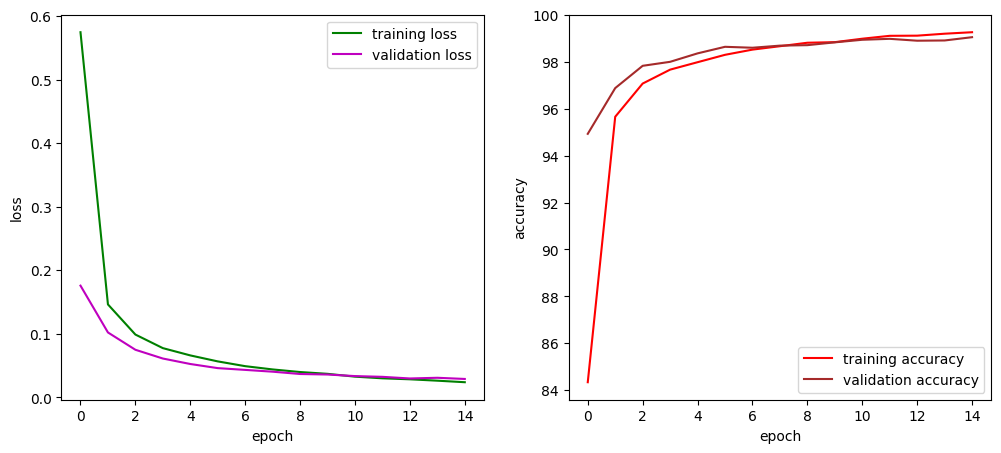

In [14]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
ax1.plot(range(epochs), running_loss_history, 'g')
ax1.plot(range(epochs), val_running_loss_history, 'm')
ax1.legend(['training loss', 'validation loss'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2 = plt.subplot(1,2,2)
ax2.plot(range(epochs), running_acc_history, 'r')
ax2.plot(range(epochs), val_running_acc_history, 'brown')
ax2.legend(['training accuracy', 'validation accuracy'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy');

### Model Performance on Validation Set:

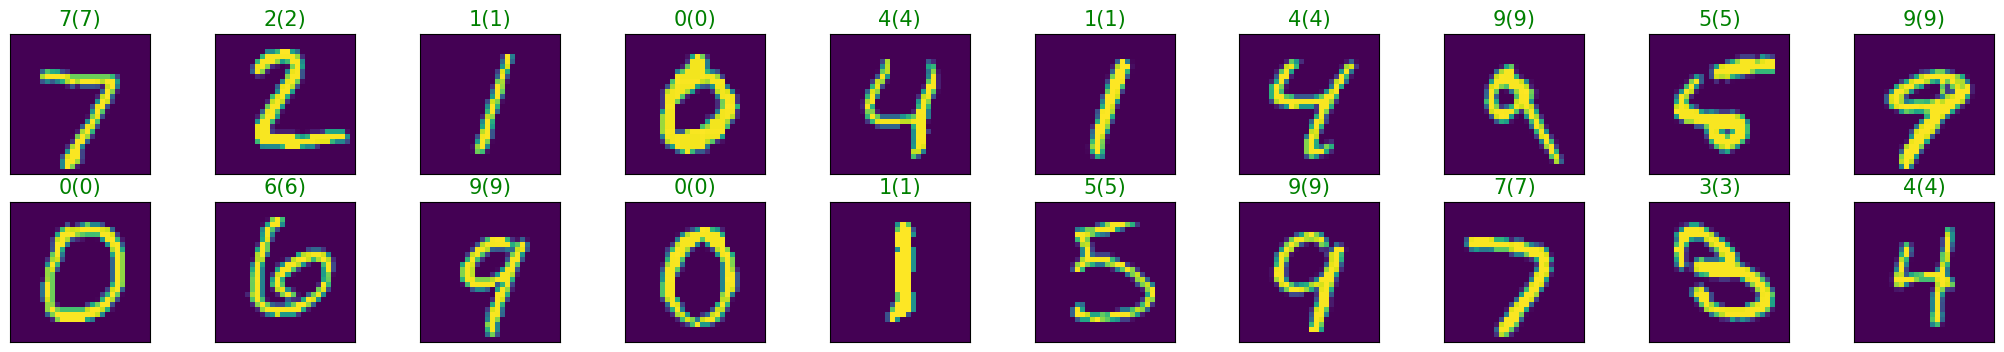

In [15]:
val_dataiter = iter(val_loader)
val_imgs, val_labels = next(val_dataiter)
val_imgs = val_imgs.to(device)
val_labels = val_labels.to(device)
plt.figure(figsize=(26,4))
for j in range(20):
    axj = plt.subplot(2,10,j+1, xticks=[], yticks=[])
    plt.imshow(image_convert(val_imgs[j]))
    # out = model(val_imgs.view(val_imgs.shape[0], -1))
    out = model(val_imgs)
    val_op, val_prd = torch.max(out,1)
    axj.set_title("{}({})" .format(val_labels[j].item(), val_prd[j].item()),
                  color=("green" if val_prd[j] == val_labels[j] else "red"), fontsize=15)

### Importing a New(single) Image:

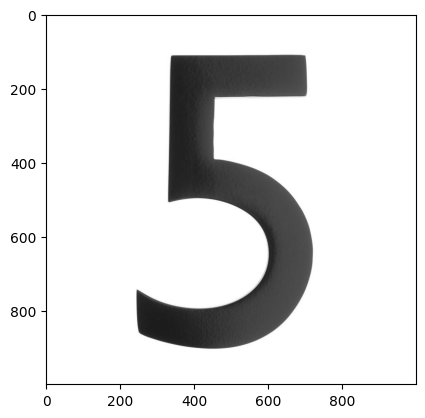

In [25]:
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img);

### Preprocessing on newly imported Image:

Image shape is =  torch.Size([1, 28, 28])


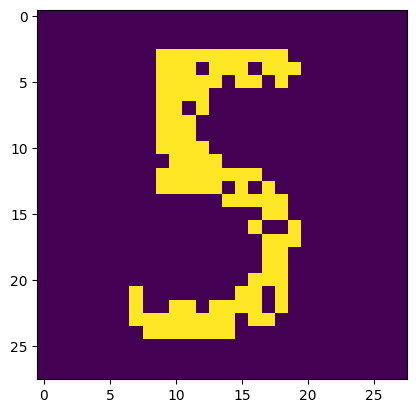

In [26]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
print('Image shape is = ', img.shape)
plt.imshow(image_convert(img));

In [27]:
img = img.to(device)
img.requires_grad = True
op = model(img)
test_, test_pred = torch.max(op,1)
print('Predicted Class for this image = ', test_pred.item())
test_loss = criteria(op, torch.tensor([test_pred.item()]).to(device))
optimizer.zero_grad()
test_loss.backward()
x_grad = img.grad.sign()
proba = F.softmax(op, dim=1)
conf = torch.max(proba)
print('Confidence: {:.2f}%' .format(conf*100))

Predicted Class for this image =  5
Confidence: 100.00%


### Un-Targeted Adversarial(FGSM) Attack:

In [28]:
eps = 0.3
x_adv = img + (eps * x_grad.to(device))
op_adv = model(x_adv)
adv_, adv_pred = torch.max(op_adv,1)
print('Now predicted class of perturbed image = ', adv_pred.item())
adv_proba = F.softmax(op_adv, dim=1)
adv_conf = torch.max(adv_proba)
print('Confidence: {:.4f}%' .format(adv_conf*100))

Now predicted class of perturbed image =  3
Confidence: 95.2369%


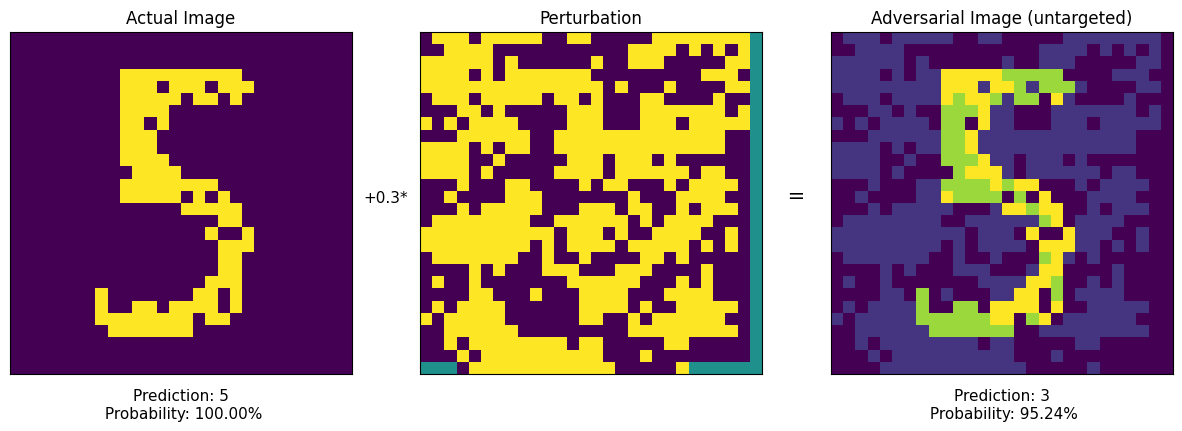

In [29]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1, xticks=[], yticks=[])
ax1.imshow(image_convert(img))
ax1.set_title('Actual Image')
ax2 = plt.subplot(1,3,2,xticks=[], yticks=[])
ax2.imshow(image_convert(x_grad.cpu()))
ax2.set_title('Perturbation')
ax3 = plt.subplot(1,3,3,xticks=[], yticks=[])
ax3.imshow(image_convert(x_adv))
ax3.set_title('Adversarial Image (untargeted)')

ax1.text(1.1,0.5,"+{}*" .format(eps), size=11, ha='center', transform=ax1.transAxes)
ax1.text(0.5,-0.13,"Prediction: {}\n Probability: {:.2f}%" .format(test_pred.item(), conf*100), size=11, ha='center', transform=ax1.transAxes)
ax3.text(0.5,-0.13,"Prediction: {}\n Probability: {:.2f}%" .format(adv_pred.item(), adv_conf*100), size=11, ha='center', transform=ax3.transAxes)
ax2.text(1.1,0.5," = " .format(eps), size=15, ha='center', transform=ax2.transAxes)
plt.show()

### Targeted Adversarial(FGSM) Attack on same image:

In [52]:
img = ''
response = requests.get(url, stream=True)
img = Image.open(response.raw)
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)

In [53]:
img = img.to(device)
img.requires_grad = True
op = model(img)

In [54]:
y_target = 8
test_loss_targeted = criteria(op, torch.tensor([y_target]).to(device))
optimizer.zero_grad()
test_loss_targeted.backward()
x_grad = img.grad.sign()
eps_targeted = 0.4
x_adv_targeted = img - (eps_targeted * x_grad.to(device))
op_adv_targeted = model(x_adv_targeted)
adv_, adv_pred_targeted = torch.max(op_adv_targeted,1)
print('Now predicted class of perturbed image = ', adv_pred_targeted.item())
adv_proba_targeted = F.softmax(op_adv_targeted, dim=1)
adv_conf_targeted = torch.max(adv_proba_targeted)
print('Confidence: {:.4f}%' .format(adv_conf_targeted*100))

Now predicted class of perturbed image =  8
Confidence: 97.5839%


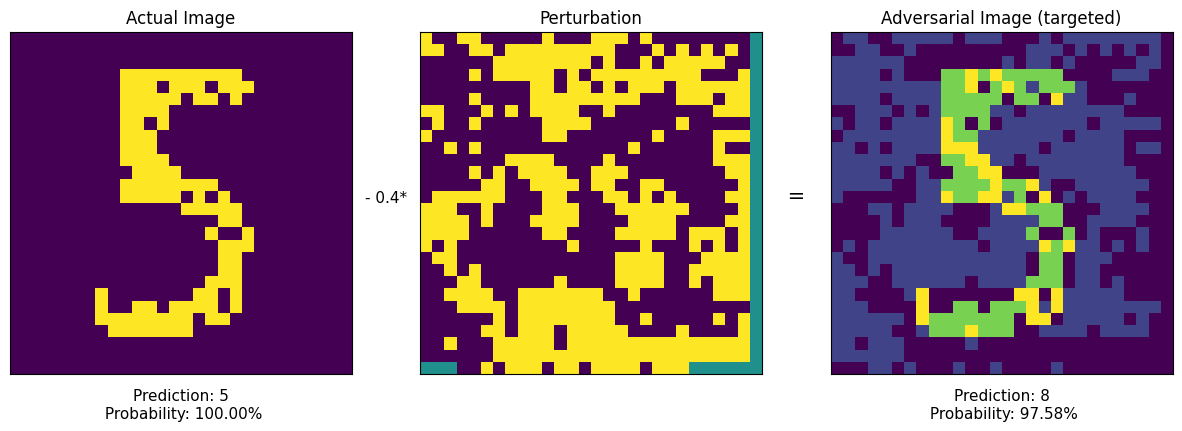

In [55]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1, xticks=[], yticks=[])
ax1.imshow(image_convert(img))
ax1.set_title('Actual Image')
ax2 = plt.subplot(1,3,2,xticks=[], yticks=[])
ax2.imshow(image_convert(x_grad.cpu()))
ax2.set_title('Perturbation')
ax3 = plt.subplot(1,3,3,xticks=[], yticks=[])
ax3.imshow(image_convert(x_adv_targeted))
ax3.set_title('Adversarial Image (targeted)')

ax1.text(1.1,0.5,"- {}*" .format(eps_targeted), size=11, ha='center', transform=ax1.transAxes)
ax1.text(0.5,-0.13,"Prediction: {}\n Probability: {:.2f}%" .format(test_pred.item(), conf*100), size=11, ha='center', transform=ax1.transAxes)
ax3.text(0.5,-0.13,"Prediction: {}\n Probability: {:.2f}%" .format(adv_pred_targeted.item(), adv_conf_targeted*100), size=11, ha='center', transform=ax3.transAxes)
ax2.text(1.1,0.5," = ", size=15, ha='center', transform=ax2.transAxes)
plt.show()